FileUpload(value={}, accept='image/*', description='Upload')

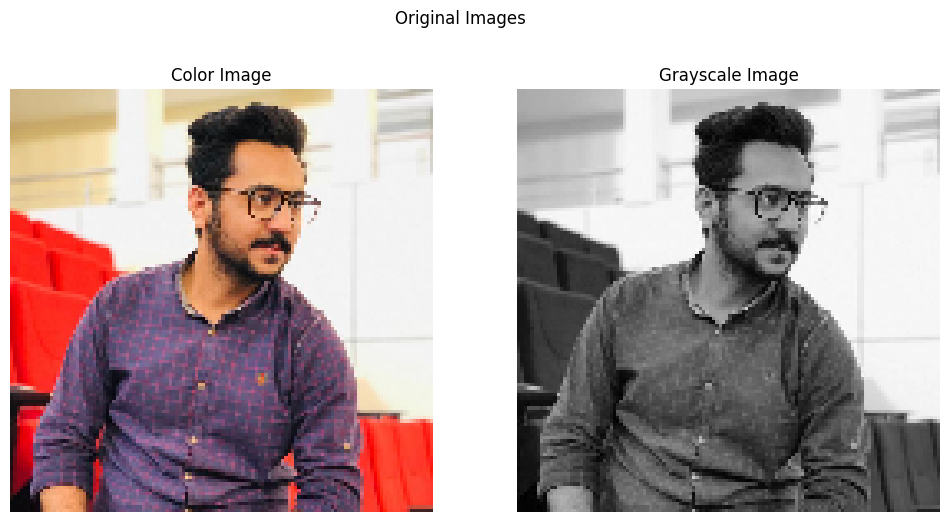

Output()

In [8]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting images
import cv2  # For image processing
import ipywidgets as widgets  # For creating interactive widgets
from IPython.display import display  # For displaying widgets in Jupyter Notebook
from skimage import io  # For reading images
from io import BytesIO  # For handling byte streams

# Function to load and resize the image while maintaining aspect ratio
def load_image(file, max_size=128):
    # Read the image from the uploaded file
    image_stream = BytesIO(file['content'])
    img_color = io.imread(image_stream)
    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Calculate new dimensions to maintain aspect ratio
    h, w = img_color.shape[:2]
    if h > w:
        new_h = max_size
        new_w = int(max_size * (w / h))
    else:
        new_w = max_size
        new_h = int(max_size * (h / w))

    # Resize both color and grayscale images
    img_color = cv2.resize(img_color, (new_w, new_h))
    img_gray = cv2.resize(img_gray, (new_w, new_h))
    return img_color, img_gray

# Function to display color and grayscale images side by side
def display_images(img_color, img_gray, title='Images'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Display the color image
    axes[0].imshow(np.clip(img_color, 0, 255).astype(np.uint8))
    axes[0].set_title('Color Image')
    axes[0].axis('off')
    # Display the grayscale image
    axes[1].imshow(np.clip(img_gray, 0, 255).astype(np.uint8), cmap='gray')
    axes[1].set_title('Grayscale Image')
    axes[1].axis('off')
    plt.suptitle(title)
    plt.show()

# Function for edge detection using Sobel operator
def edge_detection(img, sobel_strength=1):
    # Define Sobel kernels
    sobel_x = np.array([[-sobel_strength, 0, sobel_strength],
                        [-2*sobel_strength, 0, 2*sobel_strength],
                        [-sobel_strength, 0, sobel_strength]])
    sobel_y = np.array([[-sobel_strength, -2*sobel_strength, -sobel_strength],
                        [0, 0, 0],
                        [sobel_strength, 2*sobel_strength, sobel_strength]])
    if len(img.shape) == 2:  # If the image is grayscale
        # Apply Sobel operator in both x and y directions
        edges_x = cv2.filter2D(img, -1, sobel_x)
        edges_y = cv2.filter2D(img, -1, sobel_y)
        # Calculate gradient magnitude
        edges = np.sqrt(edges_x**2 + edges_y**2)
        edges = (edges / edges.max() * 255).astype(np.uint8)
    else:  # If the image is color
        edges = np.zeros_like(img)
        # Apply Sobel operator on each channel separately
        for i in range(3):
            edges_x = cv2.filter2D(img[:, :, i], -1, sobel_x)
            edges_y = cv2.filter2D(img[:, :, i], -1, sobel_y)
            edges_channel = np.sqrt(edges_x**2 + edges_y**2)
            edges[:, :, i] = (edges_channel / edges_channel.max() * 255).astype(np.uint8)
    return edges

# Function to pad the image with zeros
def pad_image(img, padding=1):
    # Pad the image with zeros
    padded_img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0) if img.ndim == 3 else np.pad(img, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    return padded_img

# Function for strided convolution
def strided_convolution(img, kernel, stride=2):
    # Calculate the output shape
    output_shape = (
        (img.shape[0] - kernel.shape[0]) // stride + 1,
        (img.shape[1] - kernel.shape[1]) // stride + 1
    )
    if img.ndim == 3:  # If the image is color
        output_shape += (img.shape[2],)
        output = np.zeros(output_shape)
        # Apply convolution on each channel separately
        for i in range(3):
            for y in range(0, img.shape[0] - kernel.shape[0] + 1, stride):
                for x in range(0, img.shape[1] - kernel.shape[1] + 1, stride):
                    output[y // stride, x // stride, i] = np.sum(img[y:y + kernel.shape[0], x:x + kernel.shape[1], i] * kernel)
    else:  # If the image is grayscale
        output = np.zeros(output_shape)
        for y in range(0, img.shape[0] - kernel.shape[0] + 1, stride):
            for x in range(0, img.shape[1] - kernel.shape[1] + 1, stride):
                output[y // stride, x // stride] = np.sum(img[y:y + kernel.shape[0], x:x + kernel.shape[1]] * kernel)
    return output

# Function for max pooling
def max_pooling(img, pool_size=2, stride=2):
    # Calculate the output shape
    output_shape = (
        (img.shape[0] - pool_size) // stride + 1,
        (img.shape[1] - pool_size) // stride + 1
    )
    if img.ndim == 3:  # If the image is color
        output_shape += (img.shape[2],)
        output = np.zeros(output_shape)
        # Apply max pooling on each channel separately
        for i in range(3):
            for y in range(0, img.shape[0] - pool_size + 1, stride):
                for x in range(0, img.shape[1] - pool_size + 1, stride):
                    output[y // stride, x // stride, i] = np.max(img[y:y + pool_size, x:x + pool_size, i])
    else:  # If the image is grayscale
        output = np.zeros(output_shape)
        for y in range(0, img.shape[0] - pool_size + 1, stride):
            for x in range(0, img.shape[1] - pool_size + 1, stride):
                output[y // stride, x // stride] = np.max(img[y:y + pool_size, x:x + pool_size])
    return output

# Interactive UI for image processing
def interactive_ui():
    # Create a file upload widget
    file_upload = widgets.FileUpload(accept='image/*', multiple=False)
    display(file_upload)
    img_color = img_gray = None

    # Function to handle file upload change
    def on_upload_change(change):
        nonlocal img_color, img_gray
        # Load and display the uploaded image
        img_color, img_gray = load_image(file_upload.value[list(file_upload.value.keys())[0]])
        display_images(img_color, img_gray, 'Original Images')
        create_interactive_widgets()

    # Function to update the image based on selected operation and parameters
    def update_operation(operation, padding=1, stride=2, pool_size=2, sobel_strength=1):
        if img_gray is None or img_color is None:
            return

        # Perform the selected operation on the images
        if operation == 'Edge Detection':
            result_gray = edge_detection(img_gray, sobel_strength)
            result_color = edge_detection(img_color, sobel_strength)
            display_images(result_color, result_gray, f'Edge Detection (Sobel Strength={sobel_strength})')
        elif operation == 'Padding':
            result_gray = pad_image(img_gray, padding)
            result_color = pad_image(img_color, padding)
            display_images(result_color, result_gray, f'Padded Image (Padding={padding})')
        elif operation == 'Strided Convolution':
            kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])  # Example kernel
            result_gray = strided_convolution(img_gray, kernel, stride)
            result_color = strided_convolution(img_color, kernel, stride)
            display_images(result_color, result_gray, f'Strided Convolution (Stride={stride})')
        elif operation == 'Max Pooling':
            result_gray = max_pooling(img_gray, pool_size, stride)
            result_color = max_pooling(img_color, pool_size, stride)
            display_images(result_color, result_gray, f'Max Pooling (Pool Size={pool_size}, Stride={stride})')

    # Function to create interactive widgets for selecting operation and parameters
    def create_interactive_widgets():
        # Dropdown for selecting operation
        operations = ['Edge Detection', 'Padding', 'Strided Convolution', 'Max Pooling']
        dropdown = widgets.Dropdown(options=operations, description='Operation:')
        # Sliders for adjusting parameters
        padding_slider = widgets.IntSlider(value=1, min=1, max=5, step=1, description='Padding:')
        stride_slider = widgets.IntSlider(value=2, min=1, max=5, step=1, description='Stride:')
        pool_size_slider = widgets.IntSlider(value=2, min=2, max=5, step=1, description='Pool Size:')
        sobel_strength_slider = widgets.IntSlider(value=1, min=1, max=5, step=1, description='Sobel Strength:')

        # Create a box for sliders
        sliders_box = widgets.VBox()

        # Function to update the sliders based on selected operation
        def update_widgets(operation):
            if operation == 'Edge Detection':
                sliders_box.children = [sobel_strength_slider]
            elif operation == 'Padding':
                sliders_box.children = [padding_slider]
            elif operation == 'Strided Convolution':
                sliders_box.children = [stride_slider]
            elif operation == 'Max Pooling':
                sliders_box.children = [pool_size_slider, stride_slider]

        # Observe changes in the dropdown and update sliders accordingly
        dropdown.observe(lambda change: update_widgets(change['new']), names='value')
        update_widgets('Edge Detection')  # Default display

        # Create interactive output
        ui = widgets.VBox([dropdown, sliders_box])
        out = widgets.interactive_output(update_operation, {
            'operation': dropdown,
            'padding': padding_slider,
            'stride': stride_slider,
            'pool_size': pool_size_slider,
            'sobel_strength': sobel_strength_slider
        })

        display(ui, out)

    # Observe changes in the file upload widget
    file_upload.observe(on_upload_change, names='value')

interactive_ui()


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
300/300 - 51s - loss: 0.4239 - accuracy: 0.8655 - val_loss: 0.0907 - val_accuracy: 0.9728 - 51s/epoch - 169ms/step
Epoch 2/10
300/300 - 45s - loss: 0.1366 - accuracy: 0.9589 - val_loss: 0.0543 - val_accuracy: 0.9818 - 45s/epoch - 150ms/step
Epoch 3/10
300/300 - 45s - loss: 0.1045 - accuracy: 0.9686 - val_loss: 0.0434 - val_accuracy: 0.9857 - 45s/epoch - 150ms/step
Epoch 4/10
300/300 - 44s - loss: 0.0836 - accuracy: 0.9746 - val_loss: 0.0356 - val_accuracy: 0.9879 - 44s/epoch - 147ms/step
Epoch 5/10
300/300 - 48s - loss: 0.0737 - accuracy: 0.9776 - val_loss: 0.0300 - val_accuracy: 0.9899 - 48s/epoch - 160ms/step
Epoch 6/10
300/300 - 45s - loss: 0.0668 - accuracy: 0.9794 - val_loss: 0.0266 - val_accuracy: 0.9911 - 45s/epoch - 150ms/step
Epoch 7/10
300/300 - 45s - loss: 0.0614 - accuracy: 0.9816 - val_loss: 0.0277 - val_accuracy: 0.9905 - 45s/epoch - 150ms/step
Epoch 8/10
300/300 - 46s - loss: 0.0560 - accuracy: 0

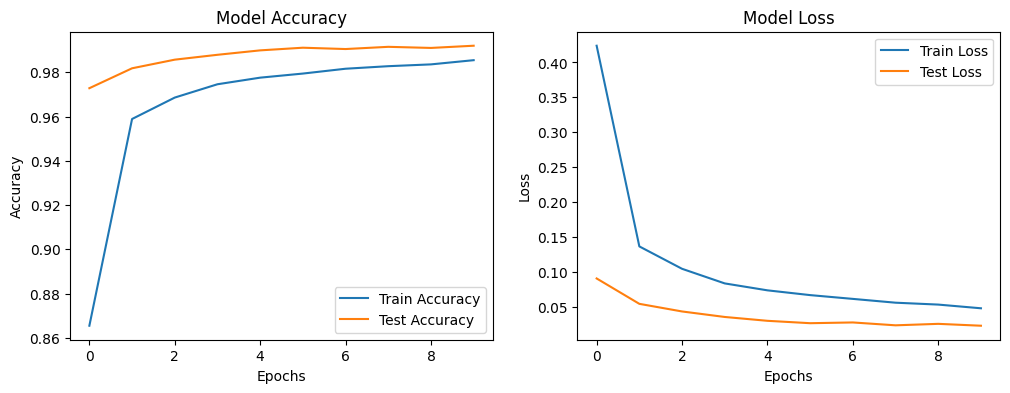

313/313 [==============================] - 4s 13ms/step


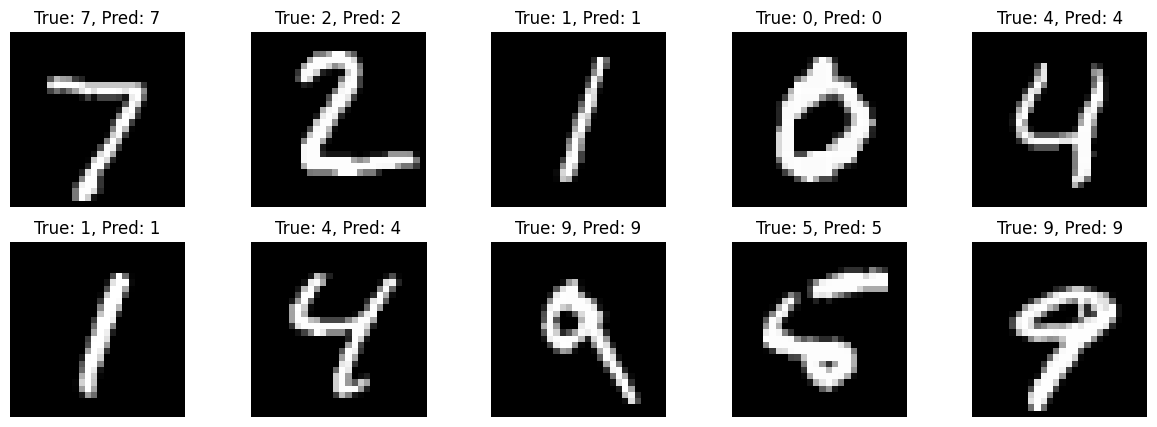

In [9]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs and images
import tensorflow as tf  # For building and training deep learning models
from tensorflow.keras.models import Sequential  # For creating a sequential model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # For adding various layers to the model
from tensorflow.keras.datasets import mnist  # For loading the MNIST dataset
from tensorflow.keras.utils import to_categorical  # For one-hot encoding the labels

# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()  # Load the dataset

# Reshape the data to include the channel dimension (28x28x1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')  # Reshape training data
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')  # Reshape testing data

# Normalize the data to the range [0, 1]
X_train /= 255  # Normalize training data
X_test /= 255  # Normalize testing data

# One-hot encode the labels
y_train = to_categorical(y_train, 10)  # One-hot encode training labels
y_test = to_categorical(y_test, 10)  # One-hot encode testing labels

# Build the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
    Dropout(0.25),  # Dropout layer to prevent overfitting
    Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
    Dropout(0.25),  # Dropout layer to prevent overfitting
    Flatten(),  # Flatten the 2D arrays into a 1D vector
    Dense(128, activation='relu'),  # Fully connected dense layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(10, activation='softmax')  # Output layer with softmax activation for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model with Adam optimizer

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)  # Train the model

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)  # Evaluate the model on the test data
print(f'Test loss: {score[0]}')  # Print test loss
print(f'Test accuracy: {score[1]}')  # Print test accuracy

# Visualize training history
plt.figure(figsize=(12, 4))  # Set the figure size

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Test Accuracy')  # Plot testing accuracy
plt.title('Model Accuracy')  # Set title
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Accuracy')  # Set y-axis label
plt.legend()  # Display legend

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(history.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Test Loss')  # Plot testing loss
plt.title('Model Loss')  # Set title
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Loss')  # Set y-axis label
plt.legend()  # Display legend

plt.show()  # Show the plots

# Visualize predictions
def visualize_predictions(model, X_test, y_test, num_samples=10):
    predictions = model.predict(X_test)  # Get predictions for the test data
    plt.figure(figsize=(15, 5))  # Set the figure size
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)  # Create subplot for each sample
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')  # Show the test image
        plt.title(f"True: {np.argmax(y_test[i])}, Pred: {np.argmax(predictions[i])}")  # Set title with true and predicted labels
        plt.axis('off')  # Hide the axes
    plt.show()  # Show the plots

visualize_predictions(model, X_test, y_test, num_samples=10)  # Visualize the predictions